<h1>
    A Time Series Analysis of the Number of Donors who Faile the Blood Tests
</h1>


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
sns.set(rc={'figure.figsize':(11, 4)})

<b>Import data into the DataFrame </b>

In [24]:
df = pd.read_excel(r'cleaned.xlsx')

In [25]:
df.head()

,Financial_Year,Branch_Code,Sequence_1,Sequence_2,Donation_type,Donor_Age,Donation_Date,Gender,Blood_Group_Code,Donor_Weight,Donor_Temperature,Donor_Pulse,Donor_Hemoglobin,Donor_Blood_Pressure,Test_1,C1,Test_2,C2,Test_3,Test_4
0,14,BRC-01,345,1.0,R,24.0,01-JUL-13,M,5.0,56.0,37.0,72.0,13.0,120/80,0.121,N,0.224,N,R,N
1,14,BRC-01,346,2.0,R,33.0,01-JUL-13,M,3.0,75.0,37.0,72.0,13.0,120/80,0.122,N,0.222,N,N,N
2,14,BRC-01,347,3.0,R,28.0,01-JUL-13,M,5.0,65.0,37.0,72.0,13.0,120/80,0.123,N,0.221,N,N,N
3,14,BRC-01,348,4.0,R,20.0,01-JUL-13,M,3.0,65.0,37.0,72.0,13.0,120/80,0.123,N,0.242,N,N,N
4,14,BRC-01,349,5.0,T,22.0,01-JUL-13,M,7.0,75.0,37.0,72.0,13.0,120/80,0.124,N,0.243,N,N,N


In [28]:
df['datetime'] = pd.to_datetime(df['Donation_Date'])

In [29]:
df = df.set_index('datetime')

<b color="blue"> Indexing done on the basis of DateTime to ease the process wof querying w.r.t to DT <\b>

In [30]:
df.index

DatetimeIndex(['2013-07-01', '2013-07-01', '2013-07-01', '2013-07-01',
               '2013-07-01', '2013-07-01', '2013-07-01', '2013-07-01',
               '2013-07-01', '2013-07-01',
               ...
               '2017-07-07', '2017-07-07', '2017-07-07', '2017-07-12',
               '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-26',
               '2017-07-26', '2017-07-26'],
              dtype='datetime64[ns]', name='datetime', length=225498, freq=None)

<b> Created a filter for the dates </b>

In [53]:
mask = (df.index >= '2013-07-01') & (df.index <= '2017-07-26')
df = df.loc[mask]

 <b> Recoded the test results as follows:
    P(ositive) and R(eactive have been assigned a value of 1. This marks them as blood samples which might not be suitable for donation. The rest of the values have been recoded to 0, denoting the presence of cases that might be good for donation. </b>

In [33]:
df.C2.replace(to_replace=dict(P=1, R=1, N=0, I=0), inplace=True)

In [34]:
df.C1.replace(to_replace=dict(R=1, N=0, I=0), inplace=True)

In [35]:
df.Test_3.replace(to_replace=dict(P=1, R=1, N=0), inplace=True)

In [36]:
df.Test_4.replace(to_replace=dict(P=1, R=1, N=0), inplace=True)

<b> Summed the values across the test results column. Purpose: the higher the value of the 'Test Failed' Column, the lower the preference

In [37]:
df["Test_Failed"] = 0
df['Test_Failed'] =  df[['C1', 'C2','Test_3','Test_4']].sum(axis=1)

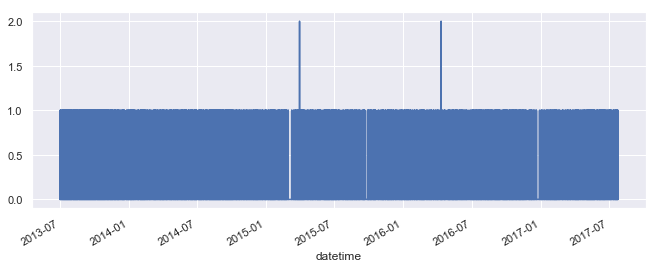

In [38]:
df["Test_Failed"].plot()

In [39]:
y = df['Test_Failed'].resample('MS').mean()

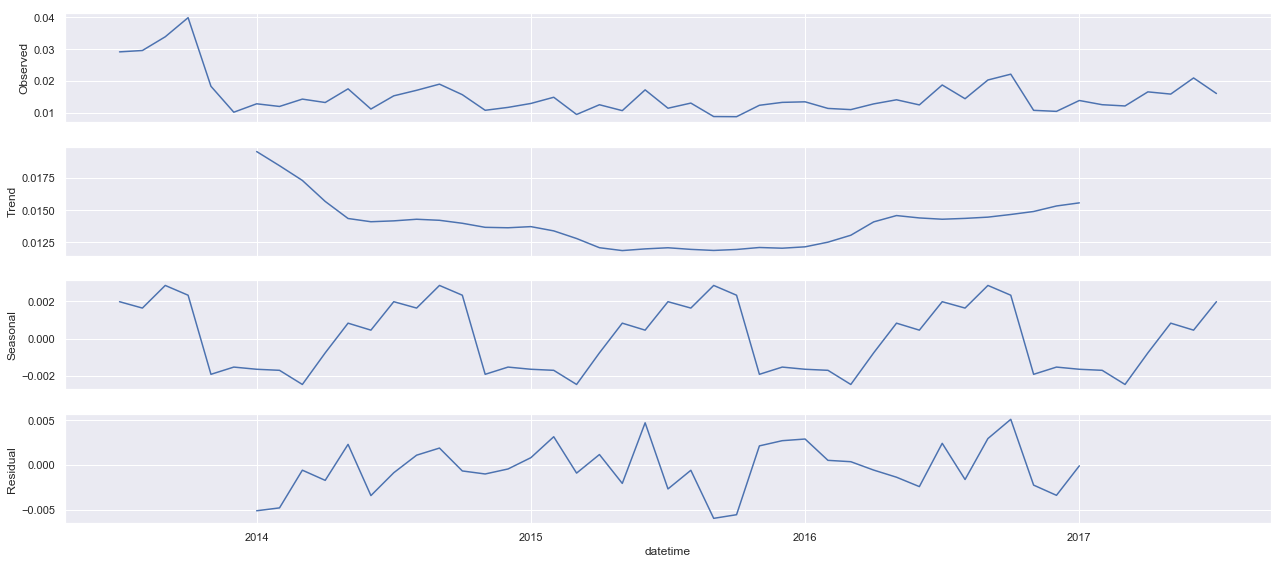

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [42]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [44]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-257.2632456575675
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-199.25848759402854
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-251.2052214565679


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
C:\Users\mmaaz\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\tools\tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
C:\Users\mmaaz\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value en

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-266.45576554488895
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-257.58654931865647
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-186.62345142744294


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-297.4681727321591
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-205.01752593769078
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-250.54052749517192


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:886.3408378560179
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-272.4300098432933
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-256.85373118114694
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-187.3550901884228
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-180.93356249682566
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-361.60474813549996
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1325.9092002171608


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-244.4924767260048
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-297.06242410289497


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1485.9909374037388
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-178.7969370249702
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-353.69453425161777


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1265.5263893772349


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-241.30090511790175
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-298.5220096972067


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1304.2611433234515
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-178.54077018662147
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-370.8291247318043
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-297.48535010977486


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-261.68565999607523


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1106.9967923029785
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-295.5768295258994


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-295.0215573592942


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-182.631840237154
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-178.10063247652883
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-362.4595425363859


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-290.38258128961974
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-253.2774542047539


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:919.3961362070639


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-300.18473220922334
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-293.3454001820132
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-180.7519810665238
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-179.34076098236656
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-360.89716162795787


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1505.042856896746
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-247.7705626860604
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-288.1512108101913


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1544.8570852382186


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-168.65155927133696


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-357.15441136793356


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1274.5390489787937


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-238.78431939714068


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-291.76659101127774


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1313.2728705777051
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-169.1520327945477


C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\mmaaz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2947      0.426      0.692      0.489      -0.540       1.130
ma.L1         -0.7295      0.291     -2.507      0.012      -1.300      -0.159
ar.S.L12      -0.3299      0.165     -2.001      0.045      -0.653      -0.007
sigma2      2.647e-05   1.07e-05      2.473      0.013    5.49e-06    4.74e-05


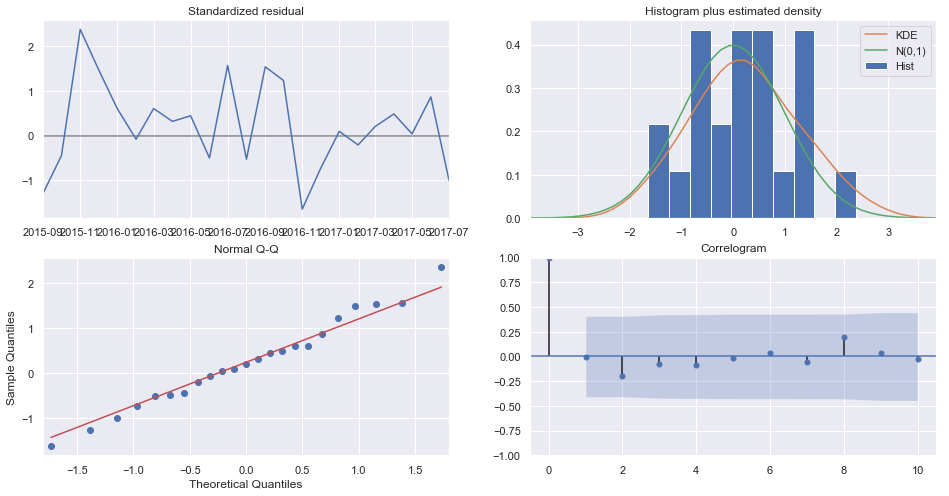

In [46]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

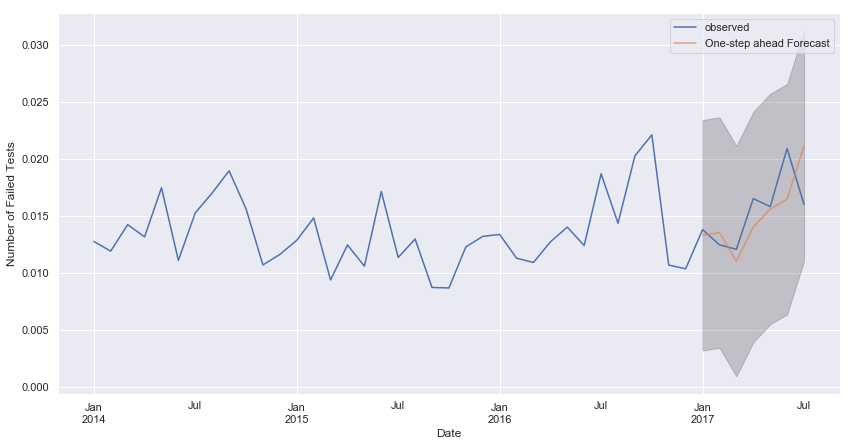

In [47]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Failed Tests')
plt.legend()
plt.show()

In [48]:
y_forecasted = pred.predicted_mean
y_truth = y['2013-07-01':'2017-07-26']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


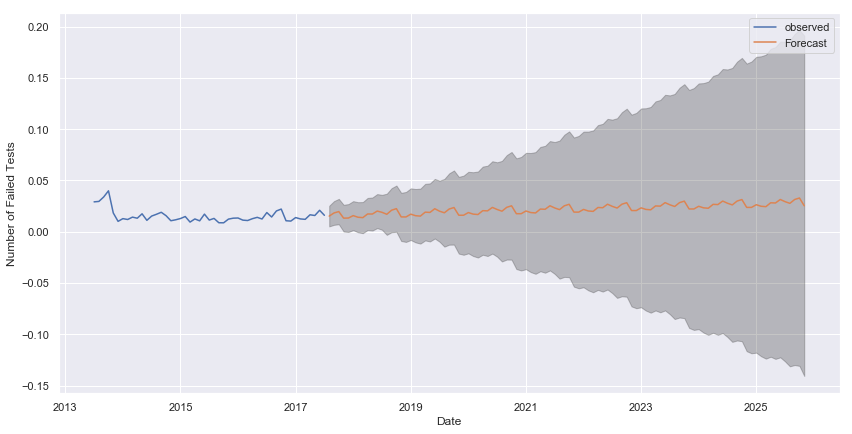

In [50]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Failed Tests')
plt.legend()
plt.show()